In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
import torch.optim as optim

In [2]:
import numpy as np
from scipy import linalg as splin

In [3]:
import matplotlib.pyplot as plt
import datetime

from tqdm import trange
from tensorboardX import SummaryWriter

The following class definitions were extracted from this pytorch normalizing flows
tutorial series: https://github.com/acids-ircam/pytorch_flows

In [191]:
class Flow(transform.Transform, nn.Module):
    """
    purpose of this class is to make `transform.Transform` 'trainable'
    simple flows will inherit it.
    
    for an explanation of why I'm setting event_dim=1 as default, see:
    https://github.com/acids-ircam/pytorch_flows/issues/2
    """
    
    def __init__(self, event_dim=1):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
        #self.bijective = True
        self.event_dim = event_dim
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

In [179]:
## Affine Flow with LU decomposition
class AffineLUFlow(Flow):
    def __init__(self, dim):
        super(AffineLUFlow, self).__init__()
        weights = torch.Tensor(dim, dim)
        nn.init.orthogonal_(weights)
        # Compute the parametrization
        P, L, U = splin.lu(weights.numpy())
        self.P = torch.Tensor(P)
        self.L = nn.Parameter(torch.Tensor(L))
        self.U = nn.Parameter(torch.Tensor(U))
        # Need to create masks for enforcing triangular matrices
        self.mask_low = torch.tril(torch.ones(weights.size()), -1)
        self.mask_up = torch.triu(torch.ones(weights.size()), -1)
        self.I = torch.eye(weights.size(0))
        # Now compute s
        self.s = nn.Parameter(torch.Tensor(np.diag(U)))
        self.bijective = True

    def _call(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ weights
    
    def _inverse(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ torch.inverse(weights)

    def log_abs_det_jacobian(self, z, y):
        return torch.sum(torch.log(torch.abs(self.s))).unsqueeze(0).repeat(z.size(0), 1)

In [180]:
# Flow version of Leaky ReLU
class PReLUFlow(Flow):
    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.bijective = True

    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(0.01, 0.99)

    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)

    def _inverse(self, z):
        return torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)

    def log_abs_det_jacobian(self, z_cur, z_next):
        I = torch.ones_like(z_cur)
        J = torch.where(z_cur >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim=1)

In [181]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z0):
        self.log_det = []
        # Applies series of flows
        z_cur = z0
        for b in range(len(self.bijectors)):
            z_next = self.bijectors[b](z_cur)
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z_cur, z_next))
            z_cur = z_next
        return z_next, self.log_det

When I first started trying these out, I wanted to be able to learn a rather simple distribution, directly from data. I think something isn't working right

In [182]:
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [183]:
def nflow_change_density(flow, z):
    # Apply our transform on coordinates
    f_z, log_det = flow(torch.Tensor(z))
    f_z = f_z.detach()
    log_det = sum(log_det).detach()
    
    
    q0_density = flow.base_density.log_prob(torch.Tensor(z)).detach().exp()
    
    # Obtain our density
    q1_density = q0_density.squeeze() / np.exp(log_det.squeeze())
    return q1_density, f_z

In [184]:
nflow = NormalizingFlow(
    dim=2, 
    blocks=[PReLUFlow],
    flow_length=1,
    density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
)

nflow.bijectors[0].alpha.data = torch.Tensor([0.6])


q0_density = nflow.base_density.log_prob(torch.Tensor(z)).exp().detach()
q1_density, f_z = nflow_change_density(nflow, z)

In [185]:
q1_density

tensor([4.9750e-08, 5.1368e-08, 5.3034e-08,  ..., 1.9093e-08, 1.8493e-08,
        1.7910e-08])

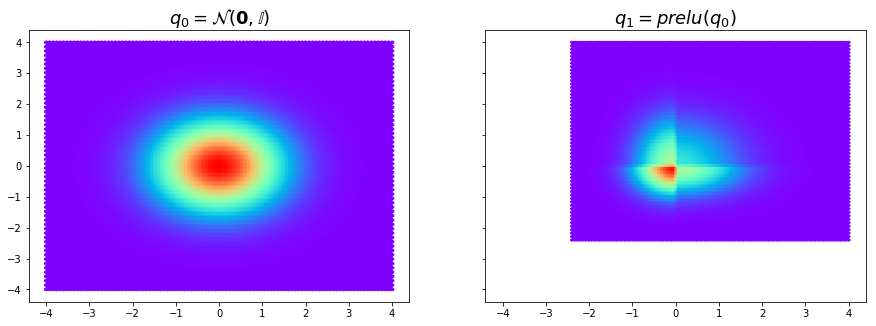

In [186]:
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=prelu(q_0)$', fontsize=18);

Now I want to make sure that `nflow.final_dist` yields the same as above

In [189]:
f_z, _ = nflow(torch.Tensor(z))
f_z = f_z.detach()

q1_density = nflow.final_density.log_prob(f_z).exp().detach()

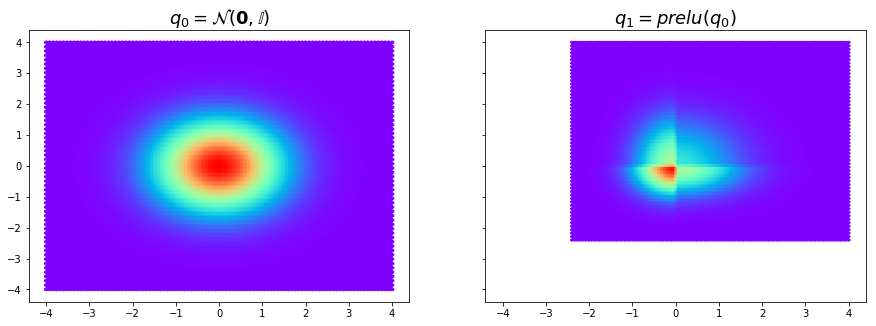

In [190]:
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=prelu(q_0)$', fontsize=18);

Trying to use different methods to plot densities

In [90]:
_z_undo = np.reshape(z, [1000, 1000, 2]).transpose(2, 0, 1)

xx = _z_undo[0]
yy = _z_undo[1]

zz = q1_density.numpy().reshape([1000, 1000])

In [98]:
zz = q0_density.numpy().reshape([1000, 1000])

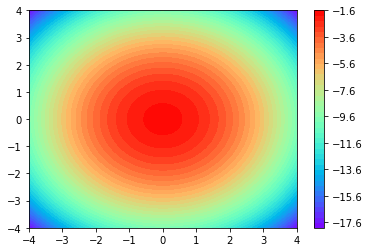

In [99]:
plt.contourf(xx, yy, zz, 50, cmap='rainbow')
plt.colorbar();

In [100]:
q1_density, f_z = nflow_change_density(nflow, z)
zz = q1_density.numpy().reshape([1000, 1000])

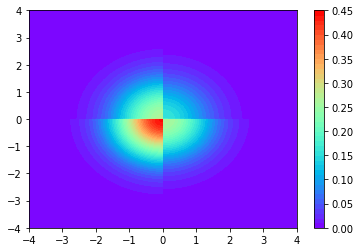

In [101]:
plt.contourf(xx, yy, zz, 50, cmap='rainbow')
plt.colorbar();

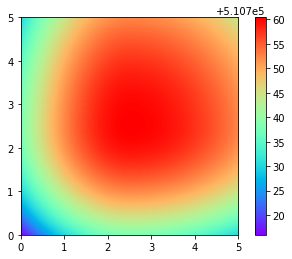

In [95]:
plt.imshow(zz, extent=[0, 5, 0, 5], origin='center', cmap='rainbow')
plt.colorbar()
plt.axis(aspect='image');